In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
%matplotlib inline

sb.set_context('paper')

In [2]:
from utils import data
from utils.data import patient_id_to_str
from utils.paper import mann_whitney_hyper_label_printer, fishers_exact_hyper_label_printer
cohort = data.init_cohort(exclude_patient_ids=set(), only_patients_with_bams=True)
cohort_df = cohort.as_dataframe(join_with=['pdl1'])
cohort_df['Response'] = cohort_df['benefit'].map(lambda v: cohort.benefit_plot_name if v
                                                 else 'No ' + cohort.benefit_plot_name)

{'dataframe_hash': 6797089423601767780,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}
inner join with pdl1: 26 to 26 rows


In [3]:
annotated_effects = cohort.load_polyphen_annotations(as_dataframe=True)

In [4]:
from pyensembl import ensembl75

In [5]:
from utils.data import patient_id_to_str
kallisto_data = pd.read_csv('../bladder-kallisto-tximport.csv', index_col=0)
kallisto_data['gene_name'] = kallisto_data.index.map(lambda gid: ensembl75.gene_name_of_gene_id(gid))
kallisto_data = kallisto_data.reset_index().drop(['index'], axis=1).set_index('gene_name').T.reset_index()
kallisto_data['patient_id'] = kallisto_data['index'].map(patient_id_to_str)
kallisto_data.head()

gene_name,index,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,RPS9,PCDHB19P,PRPF31,MBOAT7,LDHAL6FP,AC005795.1,PRKCD,OR6R2P,TSEN34,patient_id
0,40,540.2140,56.00000,649.00029,830.8775,582.19160,786.00010,454.547440,4631.10524,748.34841,...,2019.060,609.9150,289.089618,558.051916,5.5000,3.55145,2297.733000,1.00419,121.806427,0040
1,471,1133.3780,77.00000,445.99969,903.3402,456.25392,342.99990,984.792258,1619.13800,989.51800,...,3040.690,107.7640,195.470580,505.955050,6.0000,6.58465,1150.999900,1.00000,315.858201,0471
2,522,1182.8780,19.00004,1216.99897,2934.5000,1905.22708,2080.99702,3423.509560,2694.14115,5283.14540,...,2943.530,21.2127,195.200002,294.738990,17.5000,6.08811,2669.242960,1.01251,4.892077,0522
3,1233,201.0806,24.00000,225.99970,616.9180,776.95600,945.99969,1183.850300,710.33517,1073.24268,...,2863.210,175.2840,123.326675,267.840510,15.7641,0.00000,774.582010,2.12905,194.579000,1233
4,1249,312.2663,163.00000,102.99996,204.7884,498.61147,107.99996,733.000220,511.54965,356.15960,...,547.199,2.5000,54.899960,22.543993,9.0000,14.53360,50.999949,0.00000,6.626220,1249


In [6]:
from utils.paper import (
    mann_whitney_hyper_label_printer, 
    fishers_exact_hyper_label_printer, 
    hyper_label_printer, 
    fishers_exact_formatter,
)

In [7]:
# Print mutated
# Plot Fisher's Exact for mutated vs not, benefit vs not
# Mann - Whitney 
# AUC with gene expression

from cohorts.plot import mann_whitney_plot, fishers_exact_plot, roc_curve_plot

def create_gene_summary(gene_name):
    mutations = annotated_effects[annotated_effects.gene == gene_name]
    expression = kallisto_data[['patient_id', gene_name]]
    
    df = cohort_df.copy()
    
    mut_col = gene_name + ' Mutated'
    df[mut_col] = df.patient_id.isin(mutations.patient_id)
    
    expr_col = gene_name + ' scaledTPM'
    expression.rename(columns={gene_name : expr_col}, inplace=True)
    df = df.merge(expression, how='left')
    
    if len(mutations) > 0:
        cols = 3
        width = 12
        height = 4
    else:
        cols = 2
        width = 8
        height = 4
    f, ax = plt.subplots(1, cols, figsize=(width, height))
    
    if len(mutations) > 0:
        mut_plot = fishers_exact_plot(data=df, condition1='Response', condition1_value=cohort.benefit_plot_name, condition2=mut_col, ax=ax[0])
        hyper_label_printer(fishers_exact_formatter, gene_name + "_mut", results=mut_plot)
        
    expr_plot = mann_whitney_plot(data=df, 
                                  condition='Response', 
                                  distribution=expr_col, 
                                  condition_value=cohort.benefit_plot_name, 
                                  ax=ax[-2])
    mann_whitney_hyper_label_printer(expr_plot, gene_name)
    df['benefit'] = df['benefit'].astype(int)
    expr_roc = roc_curve_plot(data=df, value_column=expr_col, outcome_column='benefit', ax=ax[-1])
    f.tight_layout()
    return mutations[['patient_id', 'aa_change', 'hvar_pred', 'hvar_prob', 'hdiv_pred']]

/home/tavi/miniconda2/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


Mann-Whitney test: U=87.0, p-value=0.589908896616 (two-sided)
{{{ERCC2_plot}}}
{{{ERCC2_benefit:1231.44 (range 136.81-6170.92)}}}
{{{ERCC2_no_benefit:1128.52 (range 166.99-4159.95)}}}
{{{ERCC2_mw:n=26, Mann-Whitney p=0.59}}}
ERCC2 scaledTPM, Bootstrap (samples = 100) AUC:0.542020447564, std=0.135450086254


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


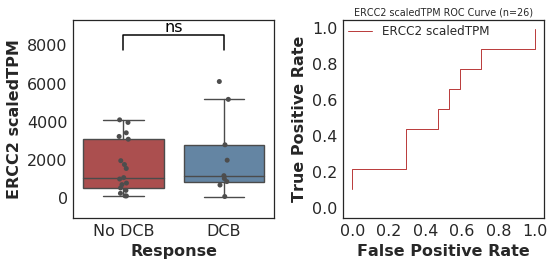

In [8]:
create_gene_summary('ERCC2')

Mann-Whitney test: U=81.0, p-value=0.829309516759 (two-sided)
{{{JAK1_plot}}}
{{{JAK1_benefit:4767.14 (range 765.00-9183.00)}}}
{{{JAK1_no_benefit:4089.77 (range 147.00-13141.81)}}}
{{{JAK1_mw:n=26, Mann-Whitney p=0.83}}}
JAK1 scaledTPM, Bootstrap (samples = 100) AUC:0.521854411892, std=0.123730370581


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


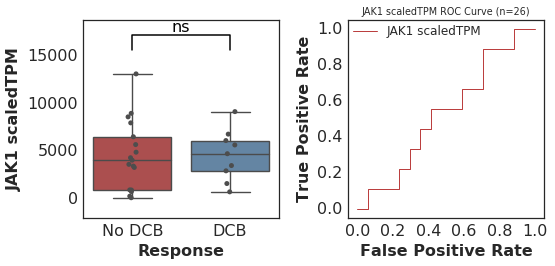

In [9]:
create_gene_summary('JAK1')

Mann-Whitney test: U=81.0, p-value=0.829309516759 (two-sided)
{{{JAK2_plot}}}
{{{JAK2_benefit:847.49 (range 165.06-1522.07)}}}
{{{JAK2_no_benefit:878.75 (range 107.49-2717.72)}}}
{{{JAK2_mw:n=26, Mann-Whitney p=0.83}}}
JAK2 scaledTPM, Bootstrap (samples = 100) AUC:0.524965804695, std=0.132023946524


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


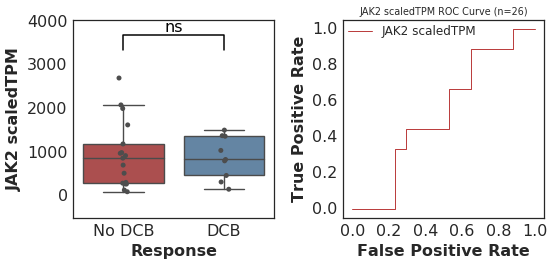

In [10]:
create_gene_summary('JAK2')

Mann-Whitney test: U=93.0, p-value=0.388495557235 (two-sided)
{{{B2M_plot}}}
{{{B2M_benefit:5402.00 (range 1566.00-22656.01)}}}
{{{B2M_no_benefit:4207.00 (range 29.00-25234.95)}}}
{{{B2M_mw:n=26, Mann-Whitney p=0.39}}}
B2M scaledTPM, Bootstrap (samples = 100) AUC:0.627304388075, std=0.125586756925


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


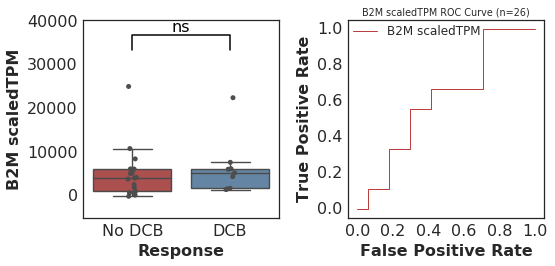

In [11]:
create_gene_summary('B2M')

FGFR3 Mutated  False  True 
Response                   
DCB                8      1
No DCB            16      1
Fisher's Exact Test: OR: 0.5, p-value=1.0 (two-sided)
{{{FGFR3_mut:n=26, Fisher's Exact p=1.00}}}
Mann-Whitney test: U=93.0, p-value=0.388495557235 (two-sided)
{{{FGFR3_plot}}}
{{{FGFR3_benefit:2073.85 (range 598.81-42675.98)}}}
{{{FGFR3_no_benefit:1297.79 (range 110.25-45804.20)}}}
{{{FGFR3_mw:n=26, Mann-Whitney p=0.39}}}
FGFR3 scaledTPM, Bootstrap (samples = 100) AUC:0.609641817224, std=0.120867331289


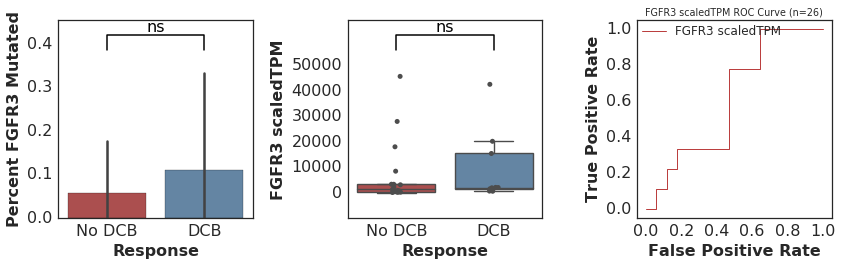

In [12]:
ax = create_gene_summary('FGFR3')

Mann-Whitney test: U=84.0, p-value=0.705967288018 (two-sided)
{{{WNT7B_plot}}}
{{{WNT7B_benefit:441.86 (range 78.24-5883.27)}}}
{{{WNT7B_no_benefit:422.49 (range 23.01-4699.22)}}}
{{{WNT7B_mw:n=26, Mann-Whitney p=0.71}}}
WNT7B scaledTPM, Bootstrap (samples = 100) AUC:0.536404626218, std=0.139863173594


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


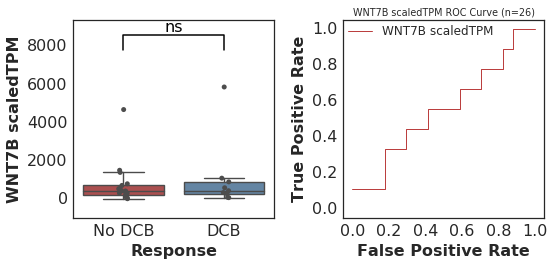

In [13]:
create_gene_summary('WNT7B')

Mann-Whitney test: U=73.0, p-value=0.871549651607 (two-sided)
{{{MYC_plot}}}
{{{MYC_benefit:2929.00 (range 148.00-13010.00)}}}
{{{MYC_no_benefit:3124.01 (range 276.00-10388.01)}}}
{{{MYC_mw:n=26, Mann-Whitney p=0.87}}}
MYC scaledTPM, Bootstrap (samples = 100) AUC:0.491680053238, std=0.13316435727


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


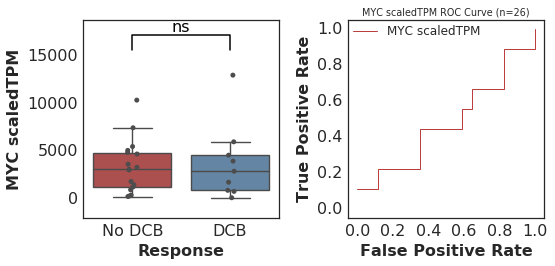

In [14]:
create_gene_summary('MYC')

Mann-Whitney test: U=65.0, p-value=0.55327159587 (two-sided)
{{{PTEN_plot}}}
{{{PTEN_benefit:1491.11 (range 368.33-2909.58)}}}
{{{PTEN_no_benefit:1883.72 (range 166.01-6410.02)}}}
{{{PTEN_mw:n=26, Mann-Whitney p=0.55}}}
PTEN scaledTPM, Bootstrap (samples = 100) AUC:0.436427527693, std=0.123086492058


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


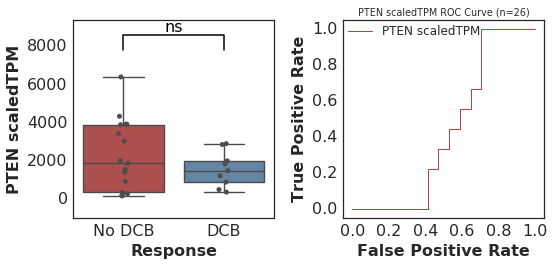

In [15]:
create_gene_summary('PTEN')